### Notebook for running SONATA on SNARE-seq dataset
Below, we replicate our results for SNARE-seq dataset reported in *SONATA: Disambiguated manifold alignment of single-cell data.*




In [1]:
import os.path as osp
import yaml
from easydict import EasyDict

import sonata
from utils.utils import *
from utils.vis import *
import scotv1

In [2]:
# load parameters and datasets
cfg_url='cfgs/SNARE-seq.yaml'
with open(cfg_url, 'r',encoding='utf8') as file:
        cfg = EasyDict(yaml.safe_load(file))
basename = osp.basename(osp.dirname(cfg.data_path.dataset_url1))
print("dataset name={}".format(basename))

data1 = load_data(cfg.data_path.dataset_url1)
data2 = load_data(cfg.data_path.dataset_url2)
label1 = load_data(cfg.data_path.label_url1)
label2 = load_data(cfg.data_path.label_url2)
print("data1 shape={}\tdata2 shape={}".format(data1.shape, data2.shape))
print("label1 shape={}\tlabel2 shape={}".format(label1.shape, label2.shape))


dataset name=SNARE-seq
data1 shape=(1047, 19)	data2 shape=(1047, 18666)
label1 shape=(1047,)	label2 shape=(1047,)


### 1. visualize two modalities

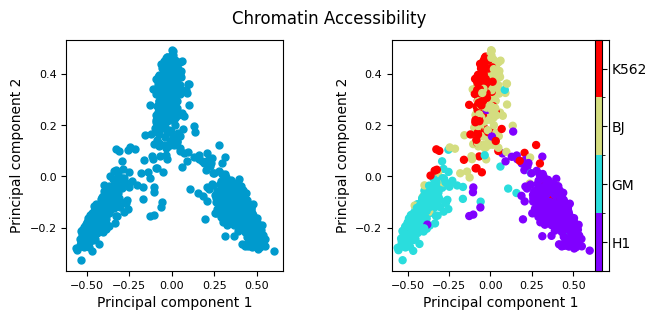

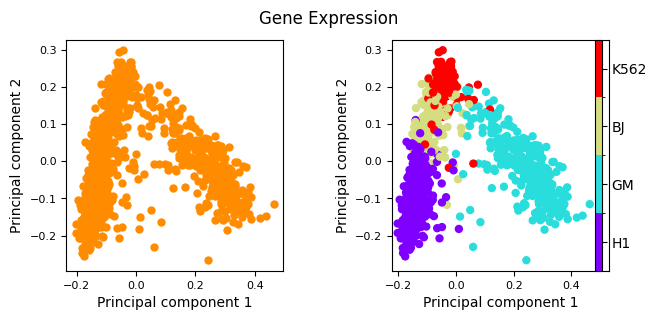

In [3]:
dm1_name = 'Chromatin Accessibility'
dm2_name = 'Gene Expression'
cell_labels = ["H1", "GM", "BJ", "K562"]

# normalize data before models(SCOT/SONATA), you can also do this step within the models seperately
from sklearn.preprocessing import normalize
data1 = normalize(data1, norm='l2', axis=1)
data2 = normalize(data2, norm='l2', axis=1)
cfg.scot.normalize=False
cfg.sonata.norm=""

plt_domain_by_biolabels(data1, label1, color="#009ACD", title=dm1_name, y_tick_labels=cell_labels, show=True)
plt_domain_by_biolabels(normalize(data2, norm='l2', axis=1), label2, color="#FF8C00", title=dm2_name, y_tick_labels=cell_labels, show=True)

### 2. Mapping by SCOT (or any other manifold aligners)

In [4]:
s_data1 = data1.copy()
s_data2 = data2.copy()
s_data2 = PCA(n_components=10).fit(s_data2).fit_transform(s_data2)

scot = scotv1.SCOT(s_data1, s_data2)
scot.align(k = cfg.scot.k, e=cfg.scot.e, mode=cfg.scot.mode, metric=cfg.scot.metric, normalize=cfg.scot.normalize)
mapping = scot.coupling
x_aligned, y_aligned = projection_barycentric(scot.X, scot.y, mapping, XontoY = cfg.plt.XontoY)

It.  |Err         
-------------------
    0|1.602145e-03|


/Users/zhouhan/Applications/anaconda3/envs/py38/lib/python3.8/site-packages/ot/bregman.py:536: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


   10|1.976784e-03|
   20|9.214826e-05|
   30|2.964002e-05|
   40|1.133073e-05|
   50|4.294301e-06|
   60|1.614160e-06|
   70|6.045029e-07|
   80|2.260567e-07|
   90|8.448808e-08|
  100|3.157059e-08|
  110|1.179603e-08|
  120|4.407340e-09|
  130|1.646692e-09|
  140|6.152428e-10|


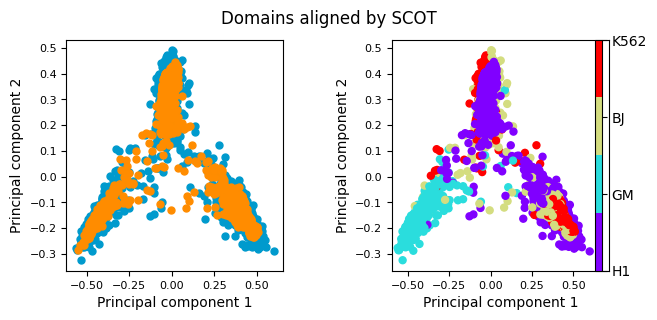

In [5]:
plt_mapping_by_biolabels(x_aligned, y_aligned, label1, label2, title1=dm1_name, title2=dm2_name, y_tick_labels=cell_labels, XontoY=cfg.plt.XontoY, show=True)

### 3. cell-cell alternaltive mappings from SONATA

In [13]:
sn = sonata.sonata(cfg.sonata)
alter_mappings = sn.alt_mapping(data=data1) 

data preprocessed by pca
constructing knn graph ...
final k =10
calculating cell-wise ambiguity ...
calculating group-wise ambiguity ...
deciding best k for clustering ...
K = 3 groups choosen by elbow method


#### 3.1 cell-cell ambiguities

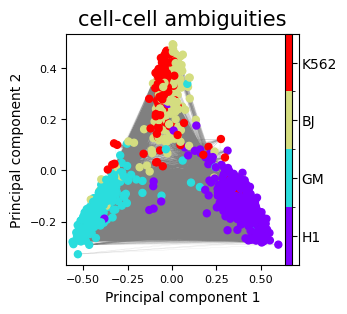

In [14]:
plt_cannotlink_by_biolabels(data1, sn.ambiguous_nodes, label1, sn.ambiguous_links, y_tick_labels=cell_labels, show=True)

#### 3.2 Ambiguous groups

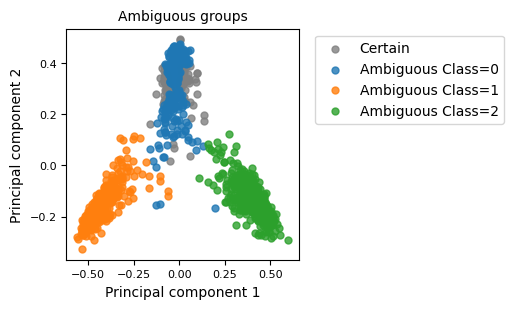

In [15]:
plt_ambiguous_groups_by_biolabels(data1, sn.ambiguous_nodes, sn.cluster_labels, alpha=0.8, show=True)

#### 3.3 k elbow to determine group numbers

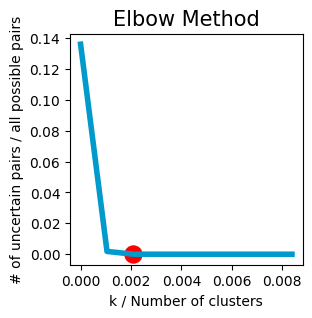

In [16]:
plt_k_elbow(x_step=sn.K_xstep, yerror=sn.K_yerror, best_k=sn.K, show=True)

#### 3.4 Alternative alignments

all vaild perms are:  [(0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]
perms:  (0, 2, 1)
changed group id:  1 2
changed group id:  2 1


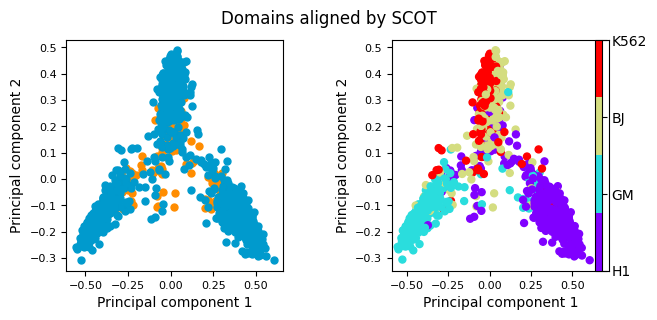

perms:  (1, 0, 2)
changed group id:  0 1
changed group id:  1 0


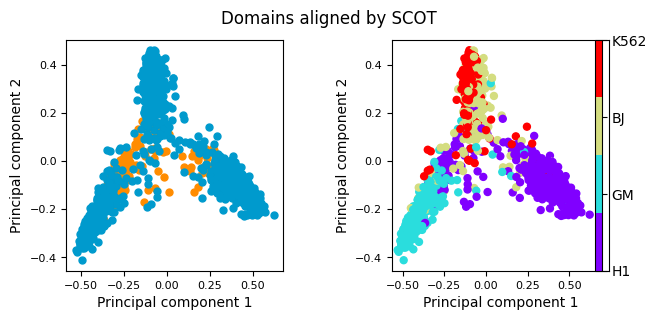

perms:  (1, 2, 0)
changed group id:  0 1
changed group id:  1 2
changed group id:  2 0


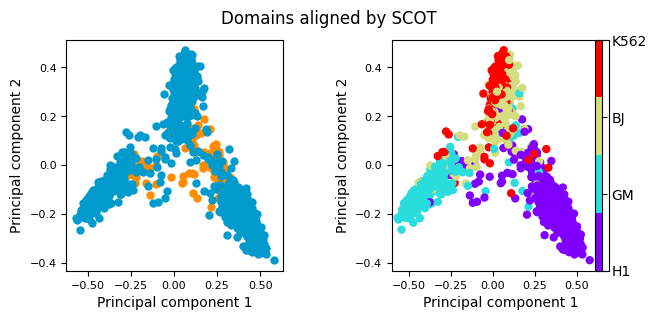

perms:  (2, 0, 1)
changed group id:  0 2
changed group id:  1 0
changed group id:  2 1


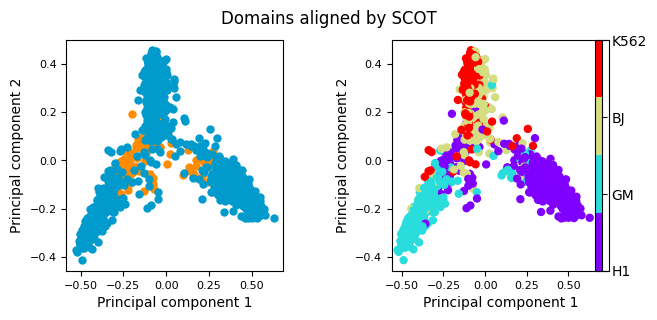

perms:  (2, 1, 0)
changed group id:  0 2
changed group id:  2 0


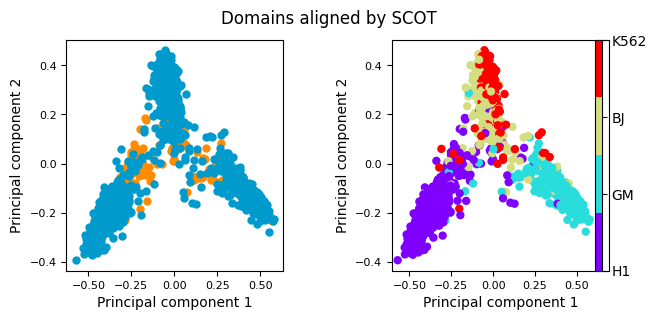

In [17]:

for idx, m in enumerate(alter_mappings, start=1):
    this_mapping = np.matmul(m, mapping)
    x_aligned, y_aligned = projection_barycentric(scot.X, scot.y, this_mapping, XontoY = cfg.plt.XontoY)
    plt_mapping_by_biolabels(x_aligned, y_aligned, label1, label2, title1=dm1_name, title2=dm2_name, y_tick_labels=cell_labels, XontoY=cfg.plt.XontoY, show=True)